# Comparing CollaGAN-3 with Pix2Pix and StarGAN

This notebook compares the images generated with CollaGAN-3 (receiving 3 source images) with Pix2Pix and StarGAN
(both receiving a single source image).

The CollaGAN model used no dropout during training. For the metrics, the Pix2Pix and StarGAN translated images from all the domains 
other than the target, and we averaged the values.

In [1]:
import gc
import logging
from time import time

import logging_utils

from ModelProxy import Pix2PixModelProxy, StarGANModelProxy, CollaGANModelProxy

logging_utils.configure()

model_loaders = {
    'pix2pix': lambda: Pix2PixModelProxy('models/pix2pix'),
    # 'stargan': lambda: StarGANModelProxy(
    #     'models/selection/stargan-capacity-and-cost/stargan-paired/all,lambda-l1-100.0,lambda-domain-1.0,lambda-reconstruction-10.0capacity-4/models/py/generator'), # went to sbgames'24 originally
    'stargan': lambda: StarGANModelProxy('models/stargan'),
    'collagan': lambda: CollaGANModelProxy('models/collagan'),
}

## Loads the Larger Dataset

These tests use the Larger dataset.


In [2]:
from dataset_utils import DatasetLoader


dataset_loader = DatasetLoader("all", "test", limit=None)

## Generates Images for a Qualitative Analysis


In [18]:
from image_utils import show_collagan3_and_baseline_comparison
import tensorflow as tf

def generate_batch_with_each_model(number_of_4batches=1, sample_numbers=None):
    mode = "random_batch" if sample_numbers is None else "specific_samples"
    batch_transpose = None
    if mode == "specific_samples":
        batch = [dataset_loader.load_paired_images(sample_number) for sample_number in sample_numbers]
        batch = tf.stack(batch, axis=0)
        batch_transpose = batch
    elif mode == "random_batch":
        # loads a batch of images
        batch = next(iter(dataset_loader.dataset.shuffle(600).batch(number_of_4batches*4).take(1)))
        batch_transpose = tf.transpose(batch, [1, 0, 2, 3, 4])
    
    genned_images = []    
    target_indices = tf.repeat(tf.range(0, 4), [number_of_4batches] * 4)
    target_images = tf.gather(batch_transpose, target_indices, batch_dims=1)
    dropped_mask = tf.one_hot(target_indices, 4, dtype=tf.float32, off_value=1.0, on_value=0.0)
    source_images = batch_transpose * dropped_mask[..., tf.newaxis, tf.newaxis, tf.newaxis]
    for model_name, model_loader in model_loaders.items():
        # loads the model into memory
        generator = model_loader()    
        # generates the images
        if model_name in ['pix2pix', 'stargan-study-network-and-sampler']:
            fake_images = []
            for sample_idx, target_domain in enumerate(target_indices):
                fake_images_of_example = []
                for source_domain in range(4):
                    if source_domain == target_domain:
                        single_fake_image = tf.ones_like(target_images[0])[tf.newaxis, ...] * -1.
                    else:
                        single_fake_image = generator.generate(source_domain, target_domain, source_images[sample_idx][:, tf.newaxis, ...])
                    fake_images_of_example += [single_fake_image]
                fake_images_of_example = tf.concat(fake_images_of_example, axis=0)
                fake_images += [fake_images_of_example]
            fake_images = tf.stack(fake_images, axis=0)

        else:
            fake_images = generator.generate_from_multiple(target_indices, source_images)

        genned_images += [fake_images]
        # frees the memory used by the model
        del generator

    # sets the target images in the source images to -1, so it becomes a checkerboard pattern when displaying
    target_in_source_mask = tf.one_hot(target_indices, 4, dtype=tf.float32)[..., tf.newaxis, tf.newaxis, tf.newaxis]
    source_images += target_in_source_mask * -1
    return source_images, target_images, genned_images, ""


starting_test_sample_numbers = stsn = {"tiny": 0, "rm2k": 136, "rmxp": 168, "rmvx": 212, "misc": 273}
example_numbers=[
    stsn["rmxp"]+25,    # rmxp maid lady
    stsn["misc"]+782,   #   
    stsn["rmxp"]+4,     # rmxp bunny tiara girl
    stsn["misc"]+207,
    stsn["misc"]+1701,  # misc tiny butt
    stsn["rm2k"]+20,  #
    stsn["rmxp"]+5,     # rmxp cook
    stsn["rmvx"]+27,    # rmvx santa
    
    # stsn["rmvx"]+37,    # rmvx fire warlock
    # stsn["misc"]+1304,  # misc crop knight
    # stsn["rmvx"]+27,    # rmvx santa
]
imgs_params = generate_batch_with_each_model(2, example_numbers)


2024-06-05 16:18:18 INFO     Start >> Loading Pix2Pix model left-to-back
D:\Projetos 2\dissertation-notebooks\.venv\lib\site-packages\keras\initializers\initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "
2024-06-05 16:18:22 INFO     End   >> Loading Pix2Pix model left-to-back
2024-06-05 16:18:22 INFO     Start >> Loading Pix2Pix model front-to-back
D:\Projetos 2\dissertation-notebooks\.venv\lib\site-packages\keras\initializers\initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to t

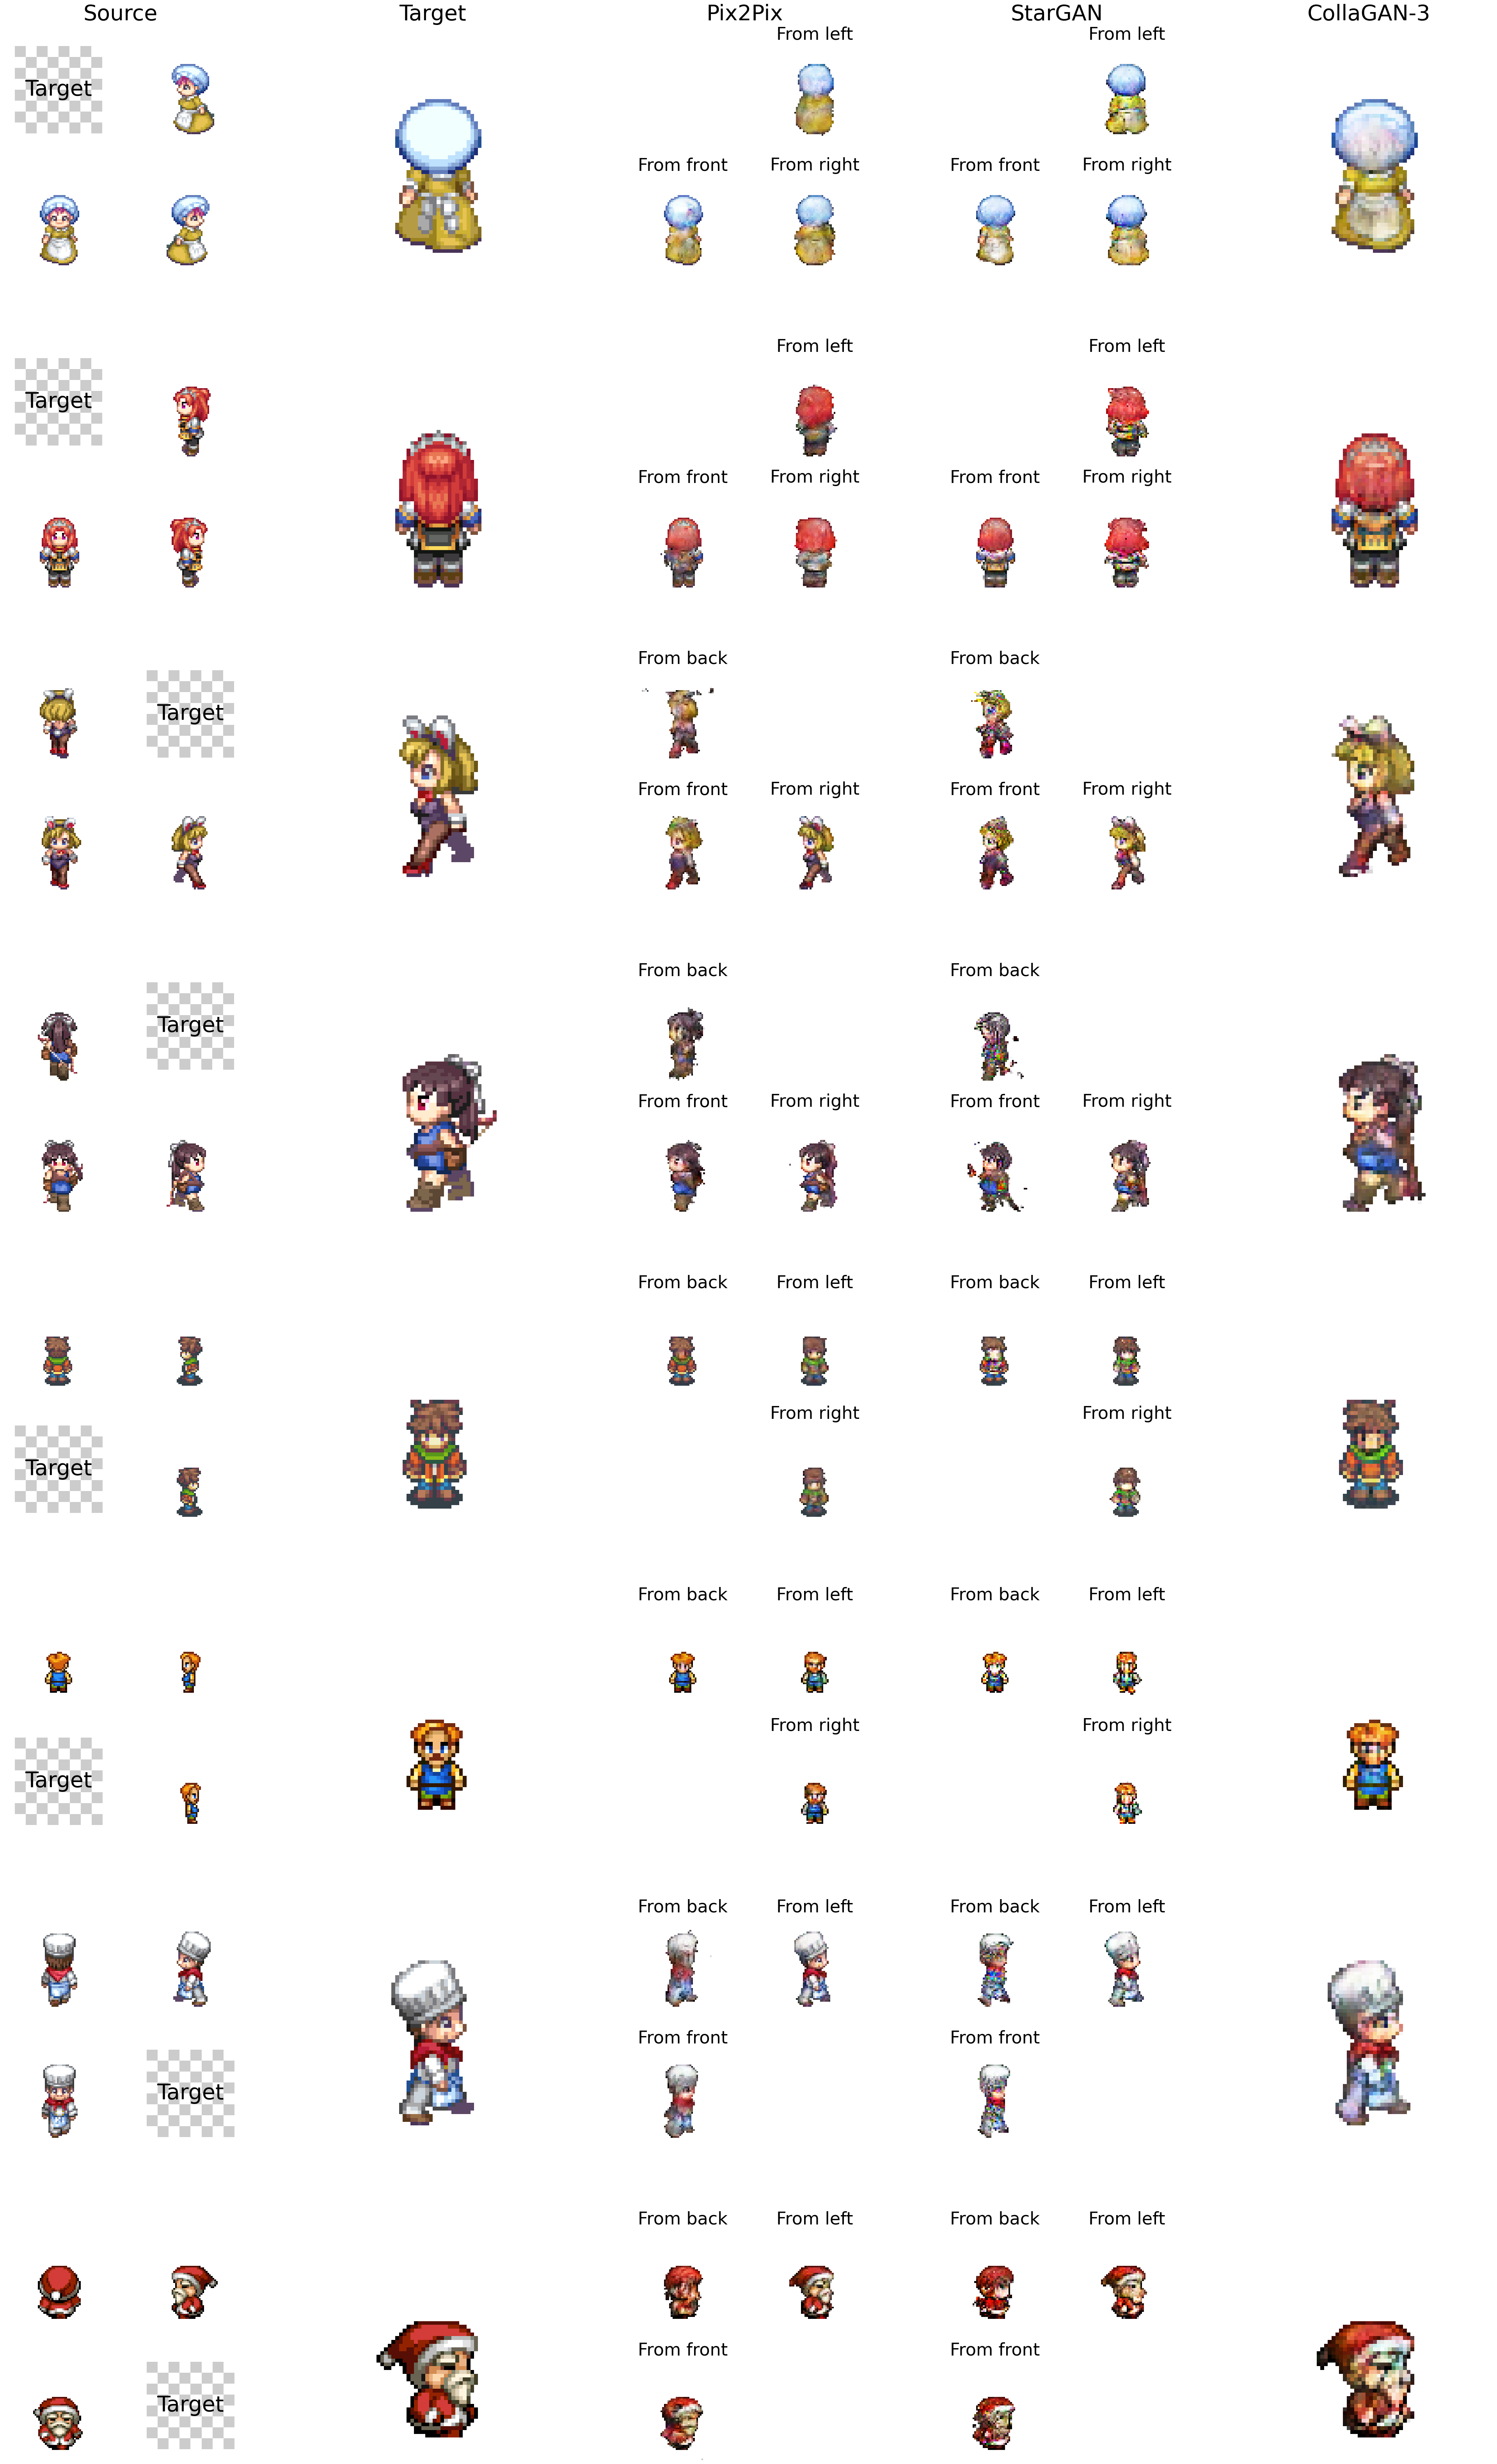

In [19]:
from matplotlib import pyplot as plt


f = show_collagan3_and_baseline_comparison(*imgs_params)
f.patch.set_alpha(0.0)
plt.savefig("output/collagan_compared_with_baseline.png", format="png", transparent=True)
